<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA

This notebook also calculates an average score (across the areas of the guest scores on various attributes such as cleanliness or service), and bucketize those scores into a binary sentiment (good = 1, bad = 0). The large data set is then sampled to a balanced sample of 5% of 444,233 reviews), and store that sample as a CSV.

In [1]:

import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pandas'

In [31]:
df_reviews = pd.read_csv('..\\data\\reviews.csv')
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,Date,ReviewID
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,"April 20, 2012",UR128207934
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,"April 11, 2012",UR127662460
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,"April 11, 2012",UR127648467
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,"April 6, 2012",UR127365749
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...","April 2, 2012",UR127143142


In [32]:
df_reviews.shape

(444233, 11)

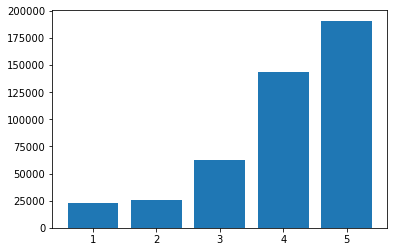

In [33]:
plt.bar([1, 2, 3, 4, 5], df_reviews['Overall'].value_counts().sort_index());

### Baseline using Overall column as targets. 

Accuracy just randomly guessing the class for an example

In [34]:
n_classes = df_reviews['Overall'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((n_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')

Baseline accuracy:  31.42%


In [35]:
# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)


In [36]:
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,average_score
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

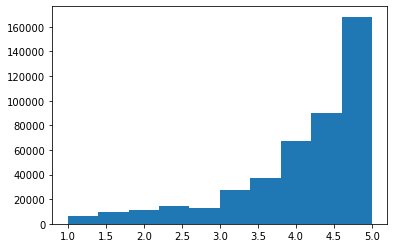

In [37]:
plt.hist(df_reviews['average_score'], bins=10);

### Approximate baseline accuracy

Guessing randomly of 10 classes accross distribution of average_scores

In [38]:
counts = np.histogram(df_reviews['average_score'], bins=10)[0]
n = df_reviews.shape[0]
baseline = np.sum((counts / n) ** 2)
print(f'Aporiximate baseline accuracy: {baseline * 100: .2f}%')

Aporiximate baseline accuracy:  22.13%


### Sample titles and descriptions by average score

In [39]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“MIGHT AS WELL SLEPT RUFF ON THE STREETS!” 
 Score =  1.00
Arrived 27/12/10 at "knightsbridge Green Hotel". Booked this hotel on off the internet. The pictures looked fantastic and location brillant.
I walked through the front door to a reception that looked dated and makeshift. Reception staff were in Jeans and jumper, not what I would
call a "4*" standard. On arrival the receptionist told me about the hotel had experienced technical difficulties...floods, electrical and
lift problems. DON'T BUY THIS. Hotel overbooked! I think this is a regular occurrance. I actually felt sorry for the receptionist as she
looked upset. She was a Actress and she should have been given an Oscar for best performance of conning customers! We got shipped off to the
sister hotel "Topham hotel" belgravia. DON'T GO THERE EITHER! Hotel just as bad. Can't swing a cat in the tiny rooms and receptionist is an
ICE MADEN. She couldn't be bothered and gave little eye contact and she was like a smili

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

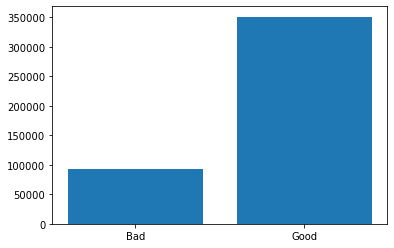

In [40]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

### Calculate a baseline accuracy

Randomly guessing 0 or 1 for each example

In [41]:
num_classes = df_reviews['sentiment'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((num_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')


Baseline accuracy:  66.89%


In [42]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Content,average_score,sentiment
256839,5,3,3,4,3,4,2,nice view architecture services need improveme...,3.428571,0
429246,5,5,4,4,4,4,3,expected intcontinental hotel second visit hot...,4.142857,1
247478,5,5,4,4,4,4,4,location location location great location hote...,4.285714,1
291147,5,5,2,5,1,5,4,left poor last impression stayed hotel two wee...,3.857143,1
129584,5,5,5,5,5,4,4,fodors choice hotel destin fodors choice spent...,4.714286,1
425003,3,3,4,4,5,4,4,good value excellent service chose hotel onewe...,3.857143,1
138681,4,4,4,4,4,4,4,clean quiet comfortable sleep inn gem nothing ...,4.000000,1
262405,5,3,3,3,3,3,3,good bad agree area kind shady stayed coceirge...,3.285714,0
211520,3,4,3,3,3,4,3,good location rooms average good location minu...,3.285714,0
113175,5,5,4,4,5,5,5,first rate another great kimpton stayed three ...,4.714286,1


### Make a CSV of a balanced sample

This way the baseline accuracy will be 50%

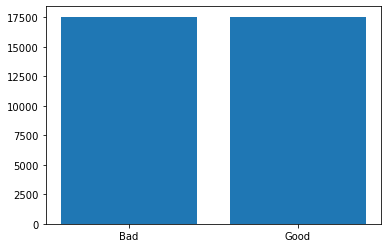

In [46]:
df1 = df_reviews[df_reviews['sentiment'] == 1].sample(frac=0.05)
rows = df1.shape[0]
df0 = df_reviews[df_reviews['sentiment'] == 0].sample(rows)
df_sampled = pd.concat([df0, df1], axis = 0)

df_sampled['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_sampled['sentiment'].value_counts().sort_index());

data_path = '..\\data\\reviews_sample.csv'
df_sampled.to_csv(data_path, index=False)
